__This notebook__ showcases how to train PRODIGE for word embeddings by directly maximizing the GloVe objective.

It's a bit rough round the edges and it uses a very small dataset, so expect some adventures :)

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=

import os, sys
sys.path.insert(0, '..')
import lib

%load_ext autoreload
%autoreload 2
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from lib.task.nlp import trainer, corpora

DATA_PATH = './corpora_tokenized'
COOC_PATH = 'cooc.pkl'

if not os.path.exists(DATA_PATH):
    !wget https://www.dropbox.com/s/s3c6swi0c32viem/toy_corpora?dl=1 -O {DATA_PATH}

data = corpora.FileDataset(DATA_PATH)
# !rm {COOC_PATH} # uncomment to rebuild cooc matrix

if os.path.exists(COOC_PATH):
    corpora = trainer.Corpus.load(COOC_PATH)
else:
    corpora = trainer.Glove.prepare_corpus(data, window=5, min_count=5, ignore_missing=True)
    corpora.save(COOC_PATH)


--2019-06-16 16:43:53--  https://www.dropbox.com/s/s3c6swi0c32viem/toy_corpora?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/s3c6swi0c32viem/toy_corpora [following]
--2019-06-16 16:43:54--  https://www.dropbox.com/s/dl/s3c6swi0c32viem/toy_corpora
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc55ec0bfd5e52342fccee221dd3.dl.dropboxusercontent.com/cd/0/get/Ai7qVjybxE4mQ_mK5bY9k-VUUCyOw3UZNgWzcFFmcFewdPg31imFu-W1HwzH9VJ3myqP5PnYqIn7feubYs0RI8kAuEa-C2MyvEXRFIS6kYwB3w/file?dl=1# [following]
--2019-06-16 16:43:55--  https://uc55ec0bfd5e52342fccee221dd3.dl.dropboxusercontent.com/cd/0/get/Ai7qVjybxE4mQ_mK5bY9k-VUUCyOw3UZNgWzcFFmcFewdPg31imFu-W1HwzH9VJ3myqP5PnYqIn7feubYs0RI8kAuEa-C2MyvEXRFIS6kYwB3w/file?dl=1
Resolving uc

In [3]:
from lib.task.nlp import make_graph_from_glove
tokens = sorted(corpora.dictionary.keys(), key=corpora.dictionary.get)

emb = make_graph_from_glove(
    corpora, n_components=100, epochs=250, verbose=True,
    knn_edges=32, random_edges=10, squared=False,
    max_length=20, n_jobs=-1, soft=True, k_nearest=0, directed=False,
)

Training base GloVe model...
Performing 250 training epochs with 34 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoc

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

loss_history, reg_history = [], []
model = lib.task.nlp.trainer.Glove(emb, corpora.dictionary, optimizer=NotImplemented)
opt = torch.optim.SparseAdam(model.parameters(), lr=0.1)
total_edges = emb.num_edges
batch_size = 256
stage = 0

def update_learning_rate():
    t = len(loss_history)
    global opt, stage, emb, batch_size
    
    if stage == 0 and t >= 3000:
        emb = emb.pruned(threshold=0.5)
        model.distance_embedding = emb
        opt = torch.optim.SparseAdam(model.parameters(), lr=0.05)
        stage += 1
    
    if stage == 1 and t >= 10000:
        emb = emb.pruned(threshold=0.5)
        model.distance_embedding = emb
        opt = torch.optim.SparseAdam(model.parameters(), lr=0.01)
        stage += 1


### Training loop

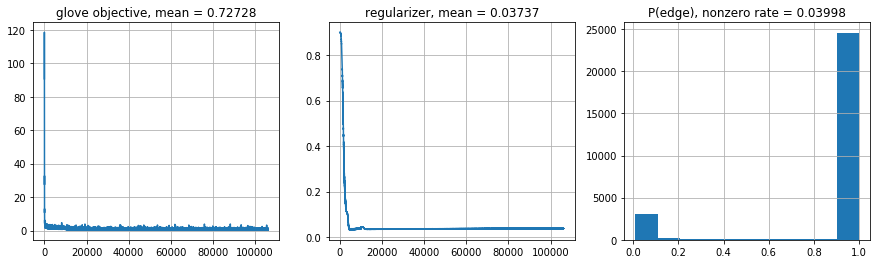

.................................................

In [ ]:
while True:
    for row_ix, col_ix, target, weight in model.iterate_minibatches(corpora.matrix, batch_size=batch_size):
        print(end='.')
        update_learning_rate()

        out = model.distance_embedding(row_ix, col_ix, max_steps=10000)
        pred = model.biases(row_ix)[..., 0] + model.biases(col_ix)[..., 0] - out['target_distances'] ** 2
        loss_values = (pred - target) ** 2
        loss = (weight * loss_values).sum() / weight.sum()
        
        regularizer = emb.compute_l0_prior_penalty(
            batch_size=4096, free_edge=True) * (emb.num_edges / total_edges)
        
        lambd = 0.1 * min(1, len(loss_history) / 10000.)
        obj = loss - out['logp_target_paths'].mean() + lambd * regularizer

        opt.zero_grad()
        obj.backward()
        opt.step()

        loss_history.append(loss.item())
        reg_history.append(regularizer.item())

        if len(loss_history) % 50 == 0:
            torch.save(model, 'glove_ms10k_checkpoint.pth')

            clear_output(True)
            plt.figure(figsize=[15, 4])
            plt.subplot(1, 3, 1);
            plt.title('glove objective, mean = %0.5f' % np.mean(loss_history[-100:])); plt.grid()
            plt.plot(loss_history)

            plt.subplot(1, 3, 2);
            plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
            plt.plot(reg_history)

            plt.subplot(1, 3, 3);
            probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().ravel()
            plt.title('P(edge), nonzero rate = %.5f' % (np.sum(probs > 0.5) / total_edges))
            plt.grid();
            plt.hist(probs)
            plt.show()

            # enforce some dropout
            with torch.no_grad():
                emb.edge_adjacency_logits.data[1:, 0].clamp_(
                    *lib.graph_embedding.inverse_sigmoid(np.array([0.01, 0.99]))
                )

    # batch/s rate will increase at 5k and 10k steps

In [6]:
print("params per vertex = %.4f" % (emb.report_model_size()['num_parameters'] / len(tokens)))

params per vertex = 3.9004


In [7]:
row_ix = torch.tensor([tokens.index('man')], dtype=torch.int32)
res = emb(row_ix, row_ix, k_nearest=10)
nearest_ix = res['nearest_vertices']
nearest_distances = res['nearest_distances']
top_k = nearest_ix[0, np.argsort(lib.check_numpy(nearest_distances)[0], axis=-1)]
top_distances = lib.check_numpy(nearest_distances[0, np.argsort(lib.check_numpy(nearest_distances)[0], axis=-1)])
print('best\tdist\ttoken')
for best_i, (index, dist) in enumerate(zip(top_k, top_distances)):
    print('%s\t%.4f\t%s' % (best_i, dist, tokens[index]))


best	dist	token
0	0.0305	woman
1	0.0443	guy
2	0.0948	baby
3	0.2792	young
4	0.2795	group
5	0.3073	person
6	0.3448	her
7	0.3483	father
8	0.3494	who
9	0.3498	kid


In [8]:
torch.save(emb, 'prodige_init_glove.final.pth')